**Loading the required packages**

In [1]:
# Importing packages for pre-processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

# Packages for embeddings
from gensim.models import KeyedVectors
#Importing packages for cleaning the data
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Importing packages for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Importing packages for visualization of results
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /Users/justin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/justin/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


**Load dataset**

In [2]:
# Path to dataset
dataset_path = '/Users/unnimaya/Documents/Projectexperiments/AIRLINEDATASET/usairlinetweets.csv'

# Load the dataset in the path using pandas
df_airline = pd.read_csv(dataset_path)

# Display the initial rows of the dataframe
df_airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df = df_airline[["airline_sentiment", "text"]]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
df["airline_sentiment"].value_counts()
#imbalanced data set
#can use resampling techniques like k fold cross validation for better accuracy

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [ ]:
#Cleaning the data
lemmatizer = WordNetLemmatizer()#Initialize lemmatizer
stop_words = set(stopwords.words('english'))#Initialize stopwords

def text_cleaning(text):
    text = text.lower()#Converting the text to lowercase
    text = re.sub(r'[^\w\s]', '', text)#Punctuation removal using regular expression
    text = re.sub(r'\d+', '', text)#Number removal
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]#Stop word removal and lemmatization
    cleaned_text = ' '.join(tokens)#Joins the tokens to form cleaned sentence   
    return cleaned_text

**TEST DATA CREATION**

In [5]:
# The column 'airline_sentiment' is label
class_label = 'airline_sentiment'

# Sample 200 datapoints from each class for the test set
test_df_class_1 = df[df[class_label] == 'negative'].sample(n=200, random_state=42)  # for class negative
test_df_class_2 = df[df[class_label] == 'neutral'].sample(n=200, random_state=42)   # for class neutral
test_df_class_3 = df[df[class_label] == 'positive'].sample(n=200, random_state=42)  # for class positive

# Concatenate test_df_class_1, test_df_class_2 and test_df_class_3 to create the test set of 600 datapoints
test_df = pd.concat([test_df_class_1, test_df_class_2, test_df_class_3])

# original dataframe minus test_data = remaining data
remaining_df = df.drop(test_df.index)

# Display the number of samples in each class for both train and test sets
# Check if the number of datapoints in remaining_df + test_df equals length of original dataframe
print("Test set class distribution:\n", test_df[class_label].value_counts())
print("Train set class distribution:\n", remaining_df[class_label].value_counts())

Test set class distribution:
 airline_sentiment
negative    200
neutral     200
positive    200
Name: count, dtype: int64
Train set class distribution:
 airline_sentiment
negative    8978
neutral     2899
positive    2163
Name: count, dtype: int64


In [6]:
# within test_df, "text" column is X and "airline_sentiment" column is Y
# These will be referred to as X_test and y_test
X_test= test_df["text"]
y_test= test_df["airline_sentiment"]

In [7]:
test_df.index

Index([ 1151,  9111,  3326, 10891, 11322,  3709,  5261, 10060, 12446,  3089,
       ...
       11705, 13422,  2716,  3071, 13504,  4489,  8271, 11795,  7294,  8203],
      dtype='int64', length=600)

In [8]:
test_df_class_1.index

Index([ 1151,  9111,  3326, 10891, 11322,  3709,  5261, 10060, 12446,  3089,
       ...
       13324, 11935,  9346, 11781,  3022, 10759, 11149,  7523, 12754,   667],
      dtype='int64', length=200)

In [9]:
test_df.shape

(600, 2)

In [10]:
df.shape

(14640, 2)

In [11]:
# Number of rows of test_df and remaining_df when summed provides the number of rows of df
remaining_df.shape

(14040, 2)

In [12]:
# There is no oversampling or undersampling involved here, so train_df= remaining_df
train_df= remaining_df

In [13]:
# When saving the weight, we are providing a prefix for the name, for ease of locating weights from this experiment
weights_path_prefix = 'Word2vec_ORIGINAL_DATA_'

### LSTM WORD2VEC

**TRAINDATA TOKENIZATION AND PADDING**

In [14]:
%%time
# Let's create a tokenizer with 10000 words (all those words which do not come under this 10000, will be marked <OOV> )
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
# Train data preprocessing
# Fitting the tokenizer on the traindata (only the text column)
tokenizer.fit_on_texts(train_df['text'])

# Data pre-processing
max_length = 200  # Maximum sequence length= 200
trunc_type = 'post'
padding_type = 'post'  # padding ensures embeddings of shorter sentences have the same length as that of the longer ones
X_train = tokenizer.texts_to_sequences(train_df['text'])  # using the tokenizer on train_df['text']
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)  # let's truncate and pad the tokens


# Let's encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['airline_sentiment'])
num_classes = len(label_encoder.classes_)   # number of classes
y_train = tf.keras.utils.to_categorical(y_train, num_classes)   # converting the labels to categorical values

CPU times: user 310 ms, sys: 5.99 ms, total: 316 ms
Wall time: 316 ms


**TESTDATA TOKENIZATION AND PADDING**

In [15]:
%%time
# test data preprocessing
# Performing the same steps of tokenizing,padding, and truncating on the test data too
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_test = label_encoder.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

CPU times: user 23.5 ms, sys: 3.95 ms, total: 27.5 ms
Wall time: 24.8 ms


**CLASS WEIGHTS**

In [16]:
import numpy as np
# Find unique classes in train_df
unique_classes = np.unique(train_df['airline_sentiment'])
class_weights = {}
# Calculate the weight for each class so that this weightage can be provided during training
for cls in unique_classes:
    class_weight = len(train_df['airline_sentiment']) / (len(unique_classes) * np.sum(train_df['airline_sentiment'] == cls))
    class_weights[cls] = class_weight

print(class_weights)
# {0: 0.5212742258854979, 1: 1.6143497757847534, 2: 2.163661581137309} class weights are because they have unequal weightage since class sizes are different for all 3 labels
class_numbers= [0, 1, 2]
class_weights= dict(zip(class_numbers,list(class_weights.values()))) 

print(class_weights)

{'negative': 0.5212742258854979, 'neutral': 1.6143497757847534, 'positive': 2.163661581137309}
{0: 0.5212742258854979, 1: 1.6143497757847534, 2: 2.163661581137309}


**WORD2VEC EMBEDDINGS and MODEL CREATION**

In [17]:
%%time
# Load Word2Vec embeddings
word2vec_path = '/Users/unnimaya/Documents/Projectexperiments/AIRLINEDATASET/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

embedding_dim = 300  # Since we loaded 300 dimensional Word2Vec mbeddings
word_index = tokenizer.word_index  # Loading word index of Word2Vec embeddings
num_words = min(10000, len(word_index) + 1)   # Number of words same as that of our tokenizer we defined above
embedding_matrix = np.zeros((num_words, embedding_dim))    # Each word has 300D, so size of embedding matrix will be 10000x300

for word, i in word_index.items():
    if i < 10000:  # if i<10000, assign embedding vector to the word from Word2Vec
        try:
            embedding_vector = word2vec[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass  # Word not found in Word2Vec, the embedding will be np.zeros((num_words, embedding_dim))
            
# Build Bidirectional LSTM model with pre-trained Word2Vec embeddings
model = Sequential()
# Create embedding for the input sequence using this first layer
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length,
                    weights=[embedding_matrix], trainable=False))
# Using a series of Bidirectional LSTMs (with recurrent dropout) followed by dropout
model.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
# After the LSTM and dropout layers, we have two fully connected neural network layers
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # number of neurons in output layer= number of classes, activation function is softmax for multiclass classification problems

# Using learning rate 0.01
learning_rate = 0.001
# Using Adam optimizer
optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0) # using clipnorm to prevent exploding gradients if any

# Compile the model with metric as accuracy and loss as categorical crossentropy (multiclass classification)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

CPU times: user 11.2 s, sys: 1.09 s, total: 12.3 s
Wall time: 12.8 s


In [20]:
# Define the checkpoint callback- decides when to save weights
checkpoint = ModelCheckpoint(
    filepath= weights_path_prefix+'_lstm_weights_trainableFalse_lr0.001_recdropouts0.2_gradientclip1_classweights_epoch_{epoch:02d}.h5',  # Filepath format to include epoch number
    save_weights_only=True,                         # Save only the model's weights
    #save_freq=10 * (len(X_train) // 32),           # Save every 30 epochs (commented for now)
    save_freq= 'epoch',                             # Save every epoch
    verbose=1                                       # Print a message when saving the weights
)

In [21]:
%%time
# TRAINING THE MODEL
# We supply test data as validation data to observe the model performance after each epoch
# 30 iterations (epochs)
# Uses class weight balancing based on class imbalance in data (no class imbalance here for oversampling)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, callbacks=[checkpoint], class_weight=class_weights)

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.6958
Epoch 1: saving model to Word2vec_ORIGINAL_DATA__lstm_weights_trainableFalse_lr0.001_recdropouts0.2_gradientclip1_classweights_epoch_01.h5
439/439 [==============================] - 1409s 3s/step - loss: 0.7554 - accuracy: 0.6958 - val_loss: 0.5919 - val_accuracy: 0.7567
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.7527
Epoch 2: saving model to Word2vec_ORIGINAL_DATA__lstm_weights_trainableFalse_lr0.001_recdropouts0.2_gradientclip1_classweights_epoch_02.h5
439/439 [==============================] - 1630s 4s/step - loss: 0.6352 - accuracy: 0.7527 - val_loss: 0.5944 - val_accuracy: 0.7850
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7642
Epoch 3: saving model to Word2vec_ORIGINAL_DATA__lstm_weights_trainableFalse_lr0.001_recdropouts0.2_gradientclip1_classweights_epoch_03.h5
439/439 [====================

In [18]:
# load and compile a saved weight
model.load_weights('Word2vec_ORIGINAL_DATA__lstm_weights_trainableFalse_lr0.001_recdropouts0.2_gradientclip1_classweights_epoch_12.h5')
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
%%time
# Use the loaded weights and evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

19/19 [==============================] - 6s 279ms/step - loss: 0.5550 - accuracy: 0.7967
Test Accuracy: 0.79666668176651
CPU times: user 9.63 s, sys: 3.37 s, total: 13 s
Wall time: 6.07 s


VISUALISATION

19/19 [==============================] - 6s 279ms/step


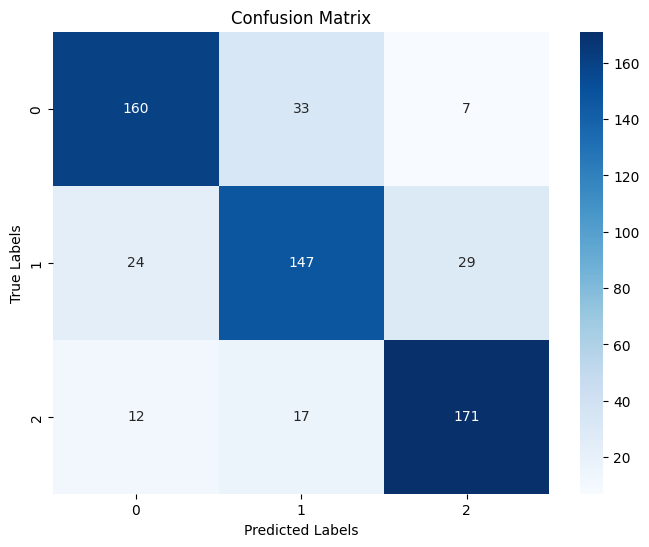

In [20]:
# Assuming X_test is your test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get the predicted class labels
y_true = np.argmax(y_test, axis=1)


# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
import numpy as np

# Assuming conf_matrix is the confusion matrix
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP

# Avoid division by zero
precision = np.divide(TP, (TP + FP), where=(TP + FP) != 0)
recall = np.divide(TP, (TP + FN), where=(TP + FN) != 0)

# Print precision and recall for each class
for i in range(len(precision)):
    print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}")

Class 0: Precision = 0.8163, Recall = 0.8000
Class 1: Precision = 0.7462, Recall = 0.7350
Class 2: Precision = 0.8261, Recall = 0.8550
